# Automatización de la Cartografía de Uso de Suelo y Cobertura del Suelo usando Python
**Esta es una obra derivada del original escrito por**: Ankur Mahesh e Isabelle Tingzon

Esta es una continuación del [Parte 1 del Tutorial de Cartografía de Uso de Suelo y Cobertura del Suelo (LULC)](https://github.com/climatechange-ai-tutorials/lulc-classification/blob/main/land_use_land_cover_part1.ipynb). Anteriormente, aprendiste cómo entrenar un modelo de aprendizaje profundo para clasificar parches de imágenes Sentinel-2 en diferentes categorías de uso de suelo y cobertura del suelo.

En este tutorial, aprenderás cómo:
- descargar tus propias imágenes satelitales Sentinel-2A usando Google Earth Engine
- usar el modelo entrenado en el tutorial anterior para generar automáticamente un mapa LULC para una región de interés

Puedes hacer una copia de este tutorial navegando a Archivo->Guardar una copia en Drive.

## Tabla de Contenidos
1. [Introducción a los Datos Geoespaciales](#geospatial)
2. [Descargar Límites de País](#lim-nac)
3. [Generar Imagen Satelital Sentinel-2](#sentinel-2)
4. [Generar Azulejos GeoJSON de 64x64 px](#tiles)
5. [Generar Mapa LULC](#lulc-maps)
6. [Conclusión y Próximos Pasos](#conclusión)


<a name="geospatial"></a>
# Introducción a los datos geoespaciales

Este tutorial es una introducción al procesamiento de datos geoespaciales con Python. Nuestro objetivo es introducir conceptos básicos y herramientas de uso común para manipular, analizar y visualizar datos geoespaciales. Nuestro público objetivo son aquellos que son nuevos en Python como herramienta para el análisis de datos geoespaciales, así como los principiantes en el análisis de datos geoespaciales y están buscando herramientas para empezar.

## Tipos de datos espaciales
Las observaciones de datos espaciales se centran en la *ubicación*. Hay dos tipos principales de datos espaciales:
- **Datos vectoriales** - son básicamente puntos, líneas y polígonos. Cada objeto vectorial puede constar de una o más ubicaciones de coordenadas XY. Los vectores se pueden utilizar para representar, por ejemplo, ubicaciones de lugares (por ejemplo, escuelas, hospitales), carreteras o fronteras de países. Los objetos vectoriales se pueden almacenar utilizando formatos de datos espaciales como GeoJSON (.geojson), GeoPackage (.gpkg), Shapefile (.shp).
- **Datos ráster**: se componen de una cuadrícula de píxeles. Los ejemplos incluyen imágenes de satélite multiespectrales, mapas de luminosidad nocturna y mapas de elevación digitales. Cada píxel representa un valor o clase, p.e. valores de rojo, verde y azul en imágenes de satélite; intensidad de la luz nocturna en mapas NTL; altura en mapas de elevación. Los datos ráster se almacenan comúnmente como GeoTIFF (.tiff).

Para obtener más información sobre vectores y ráster, [Ver esta referencia](https://gisgeography.com/spatial-data-types-vector-raster/).

<img src="https://slideplayer.com/slide/6229417/20/images/10/Spatial+data%3A+Vector+vs+Raster.jpg=100x100" width="350"/>

## Sistemas de Referencia de Coordenadas
Las proyecciones de mapas son representaciones 2D de la tierra sobre una superficie plana. Pero, dado que la tierra es esferoidal, no existe una única forma más precisa de representar la tierra en dos dimensiones, lo que da lugar a una serie de sistemas de coordenadas que sirven para diferentes propósitos (recomendado: ["Por qué todos los mapas del mundo están equivocados" de Vox](https://www.youtube.com/watch?v=kIID5FDi2JQ&ab_channel=Vox)).

**Los sistemas de referencia de coordenadas** (CRS, por sus siglas en inglés) proporcionan un método para definir ubicaciones del mundo real en el espacio geográfico. Estos sistemas determinan no solo las ubicaciones de coordenadas de los objetos, sino también cómo se ve tu mapa y cómo se calculan las distancias.

Los datos geoespaciales - ya sean vectores o ráster - siempre van acompañados de información sobre el CRS. Dos sistemas de coordenadas comunes son EPSG:3857 (Web Mercator) y EPSG:4326 (WGS 84) - en este tutorial, usaremos el CRS EPSG:4326.


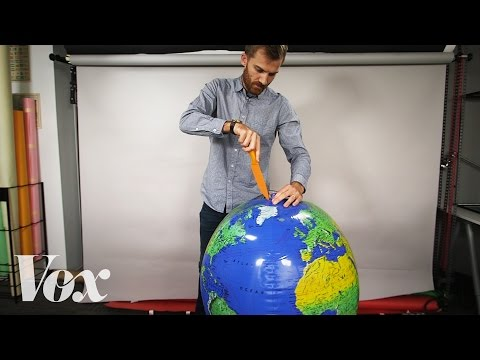

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('kIID5FDi2JQ')

## Herramientas de tratamiento de datos geoespaciales
Presentamos las siguientes herramientas de análisis geoespacial y paquetes de Python:

- [**Google Earth Engine**](https://earthengine.google.com/) - un archivo de datos público con petabytes de imágenes históricas de satélite y conjuntos de datos geoespaciales. En este tutorial, utilizaremos la [API de Motor de Tierra de Python](https://developers.google.com/earth-engine/#api) para acceder a las imágenes RGB de Sentinel-2. Tenga en cuenta que deberá registrarse para acceder a Google Earth Engine en https://code.earthengine.google.com/.
- [**GeoPandas**](https://geopandas.org/) - Amplía las funcionalidades de pandas para añadir soporte a datos geográficos y análisis geoespaciales.
- [**Rasterio**](https://rasterio.readthedocs.io/en/latest/) - Los datos ráster, como las imágenes de satélite, suelen almacenarse en formato GeoTIFF. Rasterio permite leer y escribir estos formatos y realizar operaciones geoespaciales avanzadas en estos conjuntos de datos.  
- [**Folium**](https://python-visualization.github.io/folium/) - Permite visualizar datos geoespaciales en un mapa de folletos interactivo.

Para más herramientas de análisis geoespacial, consulte esta [lista exhaustiva de paquetes Python](https://github.com/giswqs/python-geospatial).

# Importaciones y configuración

In [2]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [24]:
# Importaciones estándar.
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Paquetes de procesamiento geoespacial.
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Bibliotecas de mapeo y trazado.
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Bibliotecas de aprendizaje profundo.
import torch
from torchvision import datasets, models, transforms

### Unidad de montaje

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Autenticar el motor de Google Earth
Asegúrese de haberse registrado para acceder a Google Earth Engine en https://signup.earthengine.google.com/#!/. Una vez que se haya aprobado su solicitud, debería poder acceder a Google Earth Engine en https://code.earthengine.google.com/.

In [5]:
ee.Authenticate()
ee.Initialize(project="ee-huila333")

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


<a name="lim-nac"></a>
# Descargar límites de país

Nuestro primer paso es descargar los límites administrativos de nuestro país de interés, que obtendremos a través de [geoBoundaries por William and Mary GeoLab](https://www.geoboundaries.org/index.html). geoBoundaries es una base de datos mundial, gratuita y de libre acceso, que contiene las fronteras político-administrativas de todos los países del mundo. Los límites geográficos pueden descargarse mediante acceso API a través de una simple consulta:

```
https://www.geoboundaries.org/gbRequest.html?ISO=[3-LETTER-ISO-CODE]&ADM=[ADM-LEVEL]
```
- **ISO** - El código ISO de tres letras que representa al país de interés.
  - [Ver esta página](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes) para consultar la lista completa de códigos ISO por país.
- **ADM** - Uno de los siguientes ADM0, ADM1, ADM2, ADM3, ADM4 or ADM5, que representa cada nivel de la jerarquía administrativa.

Para más información, consulte [Documentación de la API](https://www.geoboundaries.org/api.html).

En este ejemplo, elegimos **Alemania** como zona de interés. Fijamos el código ISO en «DEU» y ADM en «ADM2». La consulta debe devolver las geometrías de los 403 distritos administrativos de Alemania. En la siguiente celda, enviamos una solicitud para los límites administrativos de Alemania, guardamos el resultado como un archivo GeoJSON, y leemos el archivo utilizando GeoPandas.

In [6]:
ISO = 'COL' # "DEU" es el código ISO de Alemania.
ADM = 'ADM1' # Equivalente a distritos administrativos.

# Consulta límites geográficos.
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Guardar el resultado como GeoJSON.
filename = 'geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Lectura de datos mediante GeoPandas.
geoboundary = gpd.read_file(filename)
print("Dimensiones de los datos: {}".format(geoboundary.shape))
geoboundary.sample(3)

Dimensiones de los datos: (33, 6)


shapeName shapeISO                  shapeID shapeGroup shapeType  \
4      Tolima   CO-TOL  13589884B56780975975491        COL      ADM1   
17    Vichada   CO-VID  13589884B14692588923622        COL      ADM1   
19  Santander   CO-SAN  13589884B55612798068582        COL      ADM1   

                                             geometry  
4   POLYGON ((-75.37526 4.80385, -75.37532 4.80365...  
17  POLYGON ((-71.07741 2.88214, -71.07427 2.88043...  
19  POLYGON ((-74.52111 6.27563, -74.52137 6.27472...

En este ejemplo, visualizamos el límite administrativo del distrito **Kreis Borken** utilizando la función GeoPandas `.plot()`.

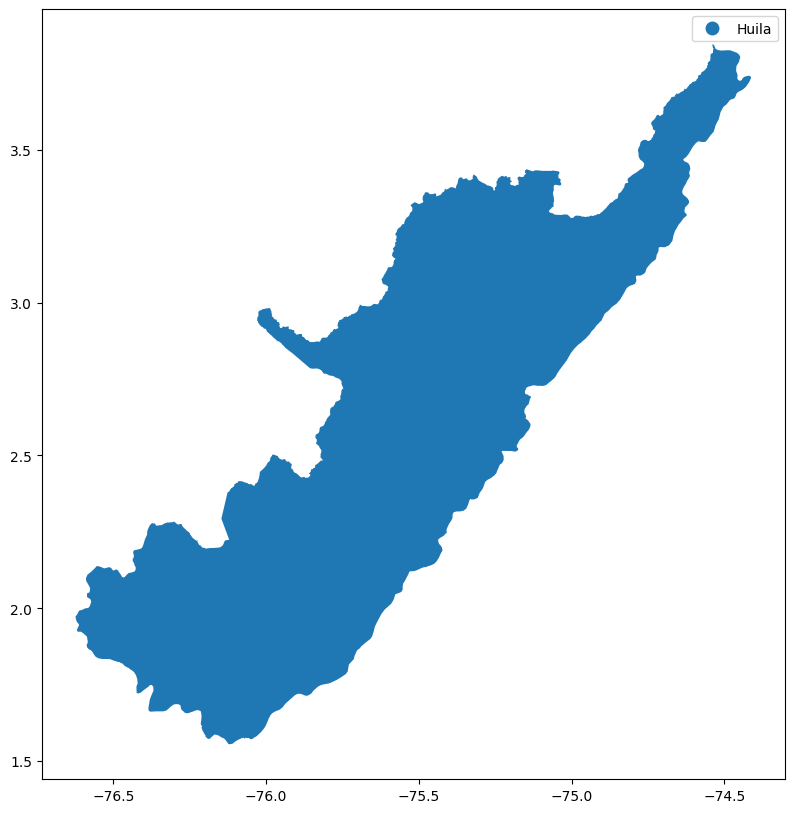

In [7]:
shape_name = 'Huila'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

<a name="sentinel-2"></a>
# Generar Imágenes Satelitales Sentinel-2
Sentinel-2 es una misión de observación de la Tierra del Programa Copernicus que proporciona imágenes multispectrales globales cada 10 días (2015 - presente) con una resolución de 10 m (es decir, la longitud de un lado de un píxel es igual a 10 metros).

Las imágenes suelen estar compuestas por 3 canales o bandas: rojo, verde y azul. Sentinel-2, por otro lado, es capaz de capturar 13 bandas espectrales:
- 4 bandas a 10 metros: azul, verde, rojo e infrarrojo cercano
- 6 bandas a 20 metros: para la caracterización de la vegetación y para aplicaciones como la detección de nieve/hielo/nubes o la evaluación del estrés por humedad en la vegetación.
- 3 bandas a 60 metros: principalmente para la detección de nubes y correcciones atmosféricas

&nbsp; &nbsp; &nbsp; &nbsp;<img src="https://www.researchgate.net/profile/Gordana_Jovanovska_Kaplan/publication/314119510/figure/tbl1/AS:670480428195846@1536866399263/Sentinel-2-band-characteristics.png" width="400"/>

Para simplificar, en este tutorial solo utilizamos las bandas Roja, Verde y Azul para la clasificación LULC. Sin embargo, los datos multispectrales contienen información valiosa que puede ser útil para una serie de aplicaciones, incluyendo estimación del rendimiento de cultivos, monitoreo de la salud de la vegetación, análisis de la expansión de áreas urbanas, detección de asentamientos informales, y mucho más. Te animamos a explorar todo el potencial de las imágenes satelitales Sentinel-2 para aplicaciones relacionadas con el clima.

[Aprende más sobre Sentinel-2 aquí](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects).



## Motor de Google Earth

En esta sección, demostraremos cómo utilizar Google Engine para descargar imágenes satelitales Sentinel-2. Nuevamente, para simplificar, solo descargaremos las bandas Sentinel-2 RGB: roja (B4), verde (B3) y azul (B2).

En la siguiente celda, definimos una función para generar una imagen de Sentinel-2 desde Google Earth usando la API de Python Earth Engine. Para minimizar la nubosidad, elegimos agregar una colección de imágenes durante un período de tiempo, en lugar de obtener una sola imagen en una fecha determinada.

In [93]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2020-01-01',
    max_date='2023-12-31',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):



    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

Generamos y visualizamos la imagen de satélite Sentinel-2 para Kreis Borken. La imagen de satélite se genera obteniendo la mediana de todas las imágenes de Sentinel-2 en 2020 con una nubosidad inferior al 10%.

In [92]:
# Obtenga la geometría de forma para Kreis Borken.
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection.

# Generar imagen RGB usando GEE.
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A.
    min_date='2020-01-01', # Obtener todas las imágenes dentro.
    max_date='2023-12-31', # El año 2021.
    cloud_pct=10, # Filtrar imágenes con nubosidad >= 10,0%.
)

# Visualizar mapa.
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

## Exportar Imagen a Google Drive Local
En la siguiente celda, definimos una función para exportar nuestra imagen satelital Sentinel-2 generada a nuestro Google Drive local.


In [94]:
def export_image(image, filename, region, folder):

"""
Exporta una imagen a Google Drive.

Args:
  image (ee.Image): Imagen generada de Sentinel-2.
  filename (str): Nombre de la imagen, sin la extensión del archivo.
  geometry (ee.Geometry): La geometría del área de interés para filtrar.
  folder (str): La carpeta de destino en tu Google Drive.

Returns:
  ee.batch.Task: Una instancia de tarea.
"""
    print('Exportando a {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()

    return task

Ahora podemos proceder a descargar la imagen a nuestro Google Drive local como GeoTIFF.

**Nota**: Tenga cuidado al exportar imágenes grandes, ya que pueden tardar un poco en descargarse y podrían consumir espacio de almacenamiento.

In [95]:
folder = 'Colab Notebooks' # Cambie esto a la carpeta de destino de su archivo en Google Drive.
task = export_image(image, shape_name, region, folder)

Exportando a Huila.tif ...


Puede ejecutar `task.status()` repetidamente para monitorear el estado de la tarea. Después de un tiempo, el estado debería cambiar de "LISTO" a "EN EJECUCIÓN" y luego a "COMPLETO".

Alternativamente, puede ir a https://code.earthengine.google.com/ para verificar el estado de la tarea.

In [102]:
task.status()

{'state': 'COMPLETED',
 'description': 'Huila',
 'priority': 100,
 'creation_timestamp_ms': 1733201214525,
 'update_timestamp_ms': 1733202258031,
 'start_timestamp_ms': 1733201222285,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1ucABwkcoLfCR7hdMwR3GZLD4Yno9q-Ft'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 7542.95849609375,
 'id': 'HYNCXSNAZCVAUP5ZC6BGPS66',
 'name': 'projects/ee-huila333/operations/HYNCXSNAZCVAUP5ZC6BGPS66'}

## Visualizar imagen de Sentinel-2A

Una vez que el estado de la tarea cambie a «COMPLETADA», comprueba que la imagen del satélite está en tu google drive.

En la siguiente celda, cargamos y visualizamos la imagen ráster del satélite utilizando la biblioteca Rasterio.

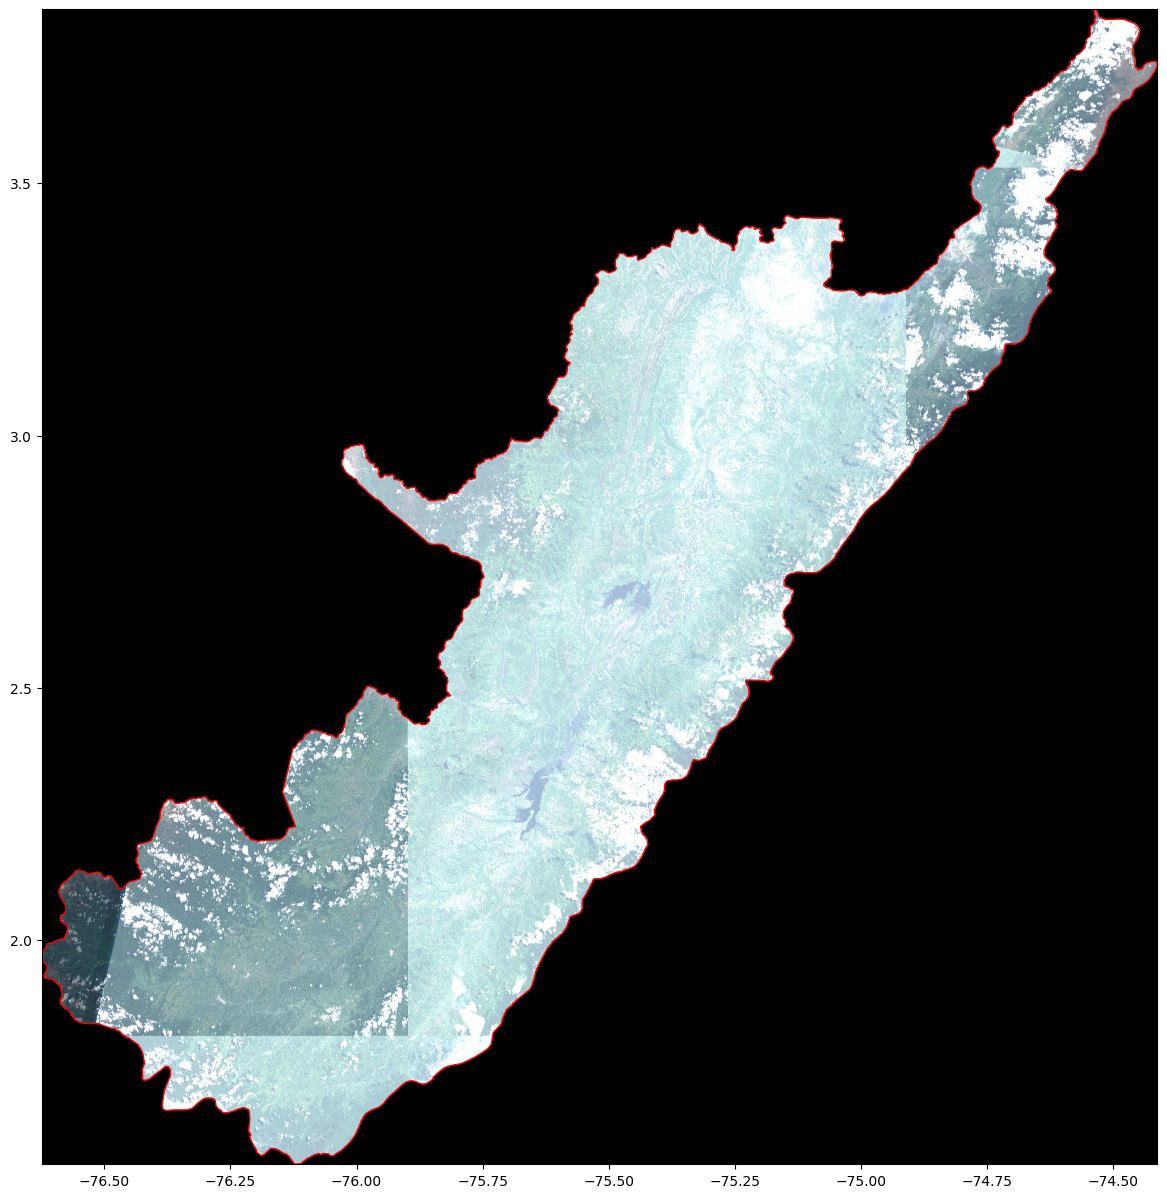

In [103]:

# Cambie esto por la ruta de su archivo de imagen.
cwd = './drive/My Drive/Colab Notebooks/'
tif_file = os.path.join(cwd, '{}.tif'.format('Huila'))

# Descomente esto para descargar el archivo TIF.
if not os.path.isfile(tif_file):
  tif_file = '{}.tif'.format('Huila')
  !gdown "12VJQBht4n544OXh4dmugqMESXXxRlBcU"

# Abrir archivo de imagen con Rasterio.
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == 'Huila']

# Imagen de la parcela y límite correspondiente.
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

<a name="tiles"></a>
# Generar mosaicos GeoJSON de 64x64 px

Recuerde que en el tutorial anterior, entrenamos un modelo de aprendizaje profundo en el [conjunto de datos EuroSAT RGB](), que consta de parches de imágenes Sentinel-2 de 64x64 píxeles. Esto significa que también necesitaremos dividir nuestra enorme imagen de Sentinel-2 en mosaicos más pequeños de 64x64 px.

Comencemos creando una función que genere una cuadrícula de polígonos cuadrados de 64x64 px usando [Utilidades de la ventana Raster](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html).





In [105]:
def generate_tiles(image_file, output_file, area_str, size=64):

"""
Genera teselas poligonales de 64 x 64.

Args:
  image_file (str): Ruta del archivo de imagen (.tif).
  output_file (str): Ruta del archivo de salida (.geojson).
  area_str (str): Nombre de la región.
  size (int): Tamaño de la ventana.

Returns:
  GeoPandas DataFrame: Contiene teselas poligonales de 64 x 64.
"""
    # Abra la imagen rasterizada usando rasterio.
    raster = rio.open(image_file)
    width, height = raster.shape

    # Cree un diccionario que contendrá nuestros mosaicos poligonales de 64 x 64 px
    # Más adelante convertiremos este dict en un GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Haga una ventana deslizante a través de la imagen rasterizada.
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Cree una ventana del tamaño deseado.
              window = rio.windows.Window(h, w, size, size)
              # Obtener los límites de la ventana georreferenciada.
              bbox = rio.windows.bounds(window, raster.transform)
              # Crea una geometría bien proporcionada desde el cuadro delimitador.
              bbox = box(*bbox)

              # Crea una identificación única para cada geometría.
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Actualizar diccionario
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Transmitir diccionario como un marco de datos de GeoPandas.
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Establezca CRS en EPSG: 4326.
    results.crs = {'init' :'epsg:4326'}
    # Guardar archivo como GeoJSON.
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

Ahora podemos crear polígonos cuadrados de tamaño 64x64 px en la imagen de satélite Kreis Borken Sentinel-2.

In [106]:
output_file = os.path.join(cwd, '{}.geojson'.format(shape_name))
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)

# Descomentar esto para descargar el archivo GeoJSON
#si no os.path.isfile(archivo_salida):
# archivo_salida = '{}.geojson'.format(nombre_forma)
# !gdown "1h7L17F0SD1xuppWddqAVh64zxH7Cjf9p"

print('Dimensiones de los datos: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/627439834 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Dimensiones de los datos: (153615, 2)


id                                           geometry
0  huila-0  POLYGON ((-76.61857 3.83913, -76.61857 3.84488...
1  huila-1  POLYGON ((-76.61282 3.83913, -76.61282 3.84488...
2  huila-2  POLYGON ((-76.60707 3.83913, -76.60707 3.84488...

## Visualizar Mosaico de 64x64 px

Abramos el archivo ráster de Sentinel-2 utilizando Rasterio y superpongamos los polígonos vectoriales de 64x64 px de la siguiente manera.


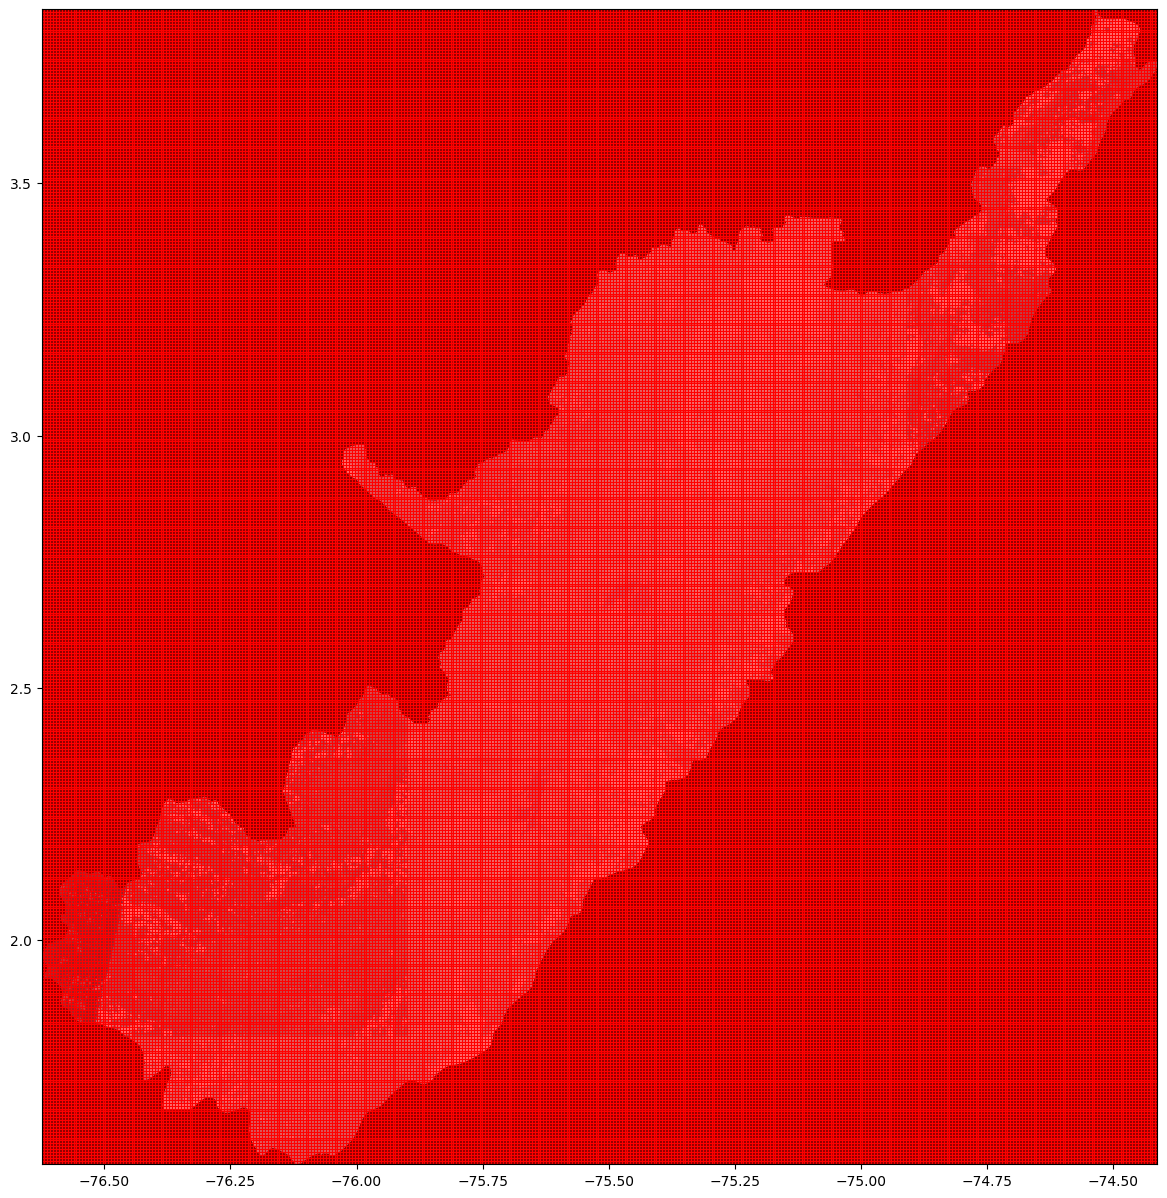

In [107]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);


Observe que los polígonos también se generan para regiones vacías (negras). Usar nuestro modelo para predecir regiones en blanco parece un desperdicio computacional.

En cambio, podemos obtener la intersección entre:
- El polígono límite del Kreis Borken y
- Los mosaicos de cuadrícula de 64 x 64.

Para hacer esto, usamos la función `.sjoin()` de GeoPandas. Establecemos el parámetro `op='within'` para indicar que solo queremos los mosaicos que se encuentran dentro de los límites del distrito.

[Vea más información sobre la operación de unión de GeoPandas aquí](https://geopandas.org/reference/geopandas.sjoin.html).





<ipython-input-108-f3cd2d87b2f7>:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary, predicate='within')


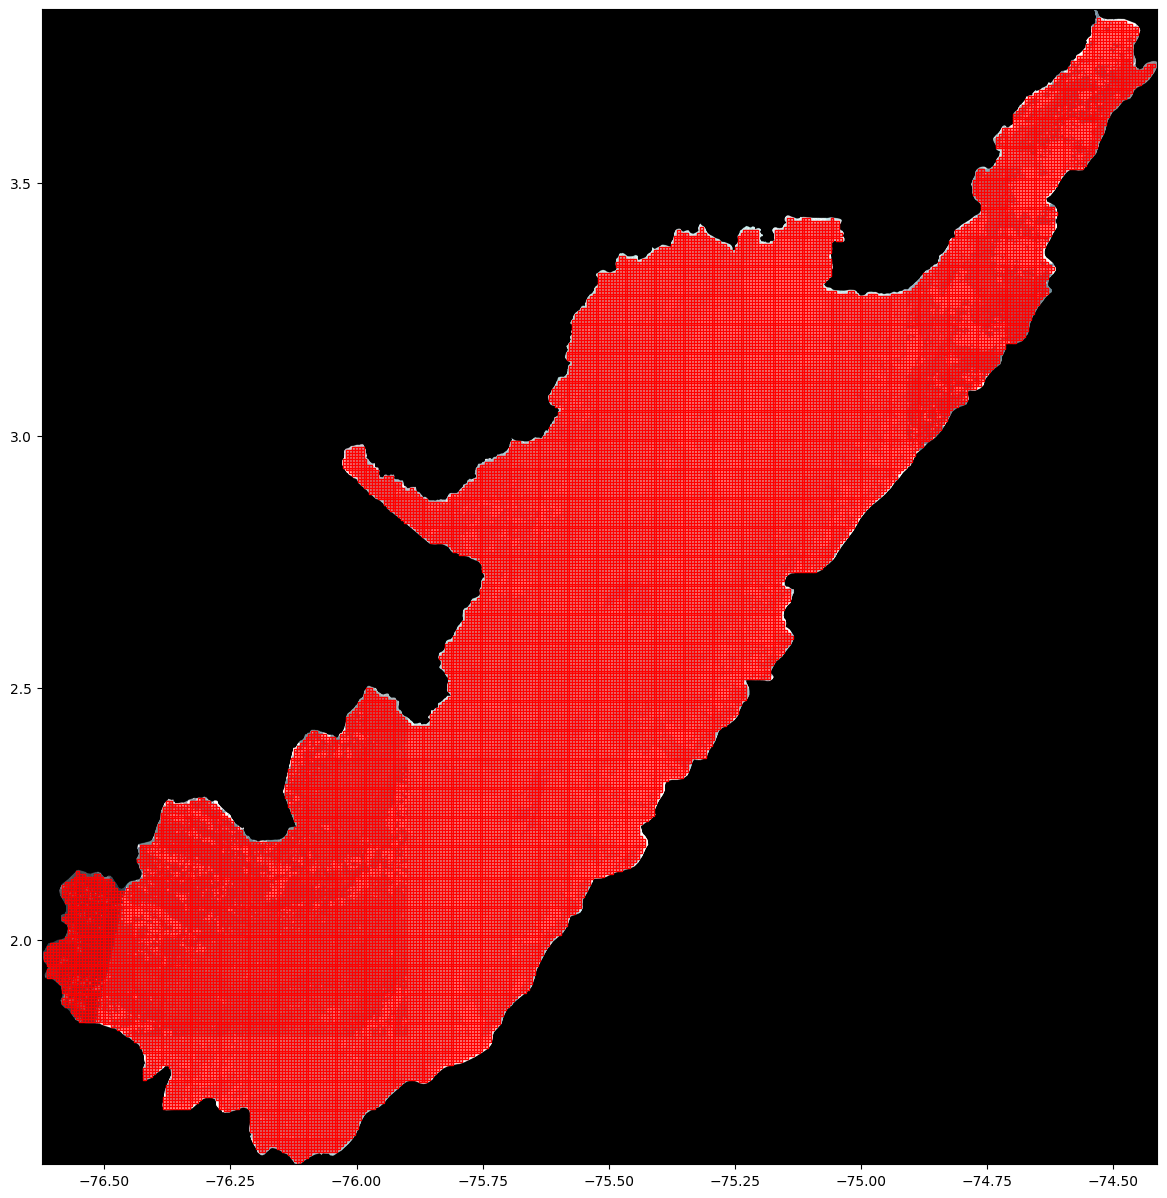

In [108]:
image = rio.open(tif_file)

# Función de unión de Geopandas.
tiles = gpd.sjoin(tiles, boundary, predicate='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Visualizar una sola imagen recortada
Ahora podemos recortar nuestra imagen Sentinel-2 utilizando las cuadrículas generadas.

Aquí visualizamos la imagen de Sentinel-2 recortada utilizando el primer mosaico.

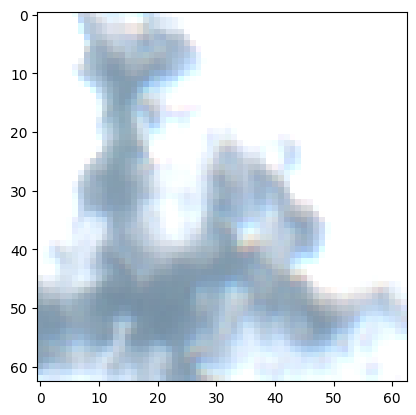

In [109]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])


<a name="lulc-maps"></a>
# Generar mapa de uso y cobertura del suelo
En esta sección, generaremos nuestro mapa de clasificación de uso y cobertura del suelo utilizando el modelo entrenado del tutorial anterior. Recuerde que el conjunto de datos de EuroSAT consta de 10 clases LULC diferentes, como se enumeran a continuación.

In [110]:
# Clases LULC.
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

## Cargar el Modelo Entrenado en EuroSAT
Primero, carga tu modelo entrenado.

En caso de que te hayas perdido la Parte 1 del tutorial, también puedes descomentar el código a continuación para descargar el modelo entrenado directamente.


In [111]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = cwd+'/models/best_model.pth'

# Descomentar esto para descargar el archivo del modelo.
if not os.path.isfile(model_file):
  model_file = 'best_model.pth'
  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Arcivo del modelo {} cargado correctamente.'.format(model_file))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-111-15eead59b5dc>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta

Arcivo del modelo ./drive/My Drive/Colab Notebooks//models/best_model.pth cargado correctamente.


Recuerde en el tutorial anterior que aplicamos un conjunto de transformaciones de datos a nuestro conjunto de prueba. Antes de ejecutar nuestras nuevas imágenes a través del modelo, necesitaremos aplicar la misma transformación a nuestros nuevos datos como se muestra a continuación.

In [112]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## Predicción de modelos y generación de mapas LULC

A continuación, vamos a definir una función que:
1. Recorta la imagen de origen utilizando la geometría de mosaico 64x64
2. Genere una predicción para la imagen recortada utilizando el modelo entrenado.

In [113]:
def predict_crop(image, shape, classes, model, show=False):
    """Genera la predicción del modelo utilizando el modelo entrenado

    Args:
      image (str): Ruta del archivo de imagen (.tiff)
      shape (geometry): El mosaico con el que se recorta la imagen
      classes (list): Lista de clases LULC

    Retornar
      str: Etiqueta prevista
    """

    with rio.open(image) as src:
        # Recorta la imagen de origen usando la forma poligonal.
        # Ver más información aquí:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Recortar el borde negro (cero).
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Obtener los metadatos de la imagen de origen y actualizarlos
        # con la anchura, altura y transformación de la imagen recortada.
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Guarde la imagen recortada como un archivo TIFF temporal.
        temp_tif = 'temp.tif'
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Abrir la imagen recortada y la predicción generada
        # utilizando el modelo Pytorch entrenado.
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

Vamos a iterar sobre cada mosaico de 64x64 px y generar predicciones de modelo para la imagen recortada correspondiente. Tenga en cuenta que estamos sobrescribiendo cada archivo TIFF temporal para ahorrar espacio de almacenamiento.

In [ ]:
'''
import numpy as np
import rasterio as rio
from PIL import Image

def predict_crop(image, shape, classes, model, show=False):
    """Genera la predicción del modelo utilizando el modelo entrenado

    Args:
      image (str): Ruta del archivo de imagen (.tiff)
      shape (geometry): El mosaico con el que se recorta la imagen
      classes (list): Lista de clases LULC

    Retornar
      str: Etiqueta prevista
    """

    with rio.open(image) as src:
        # Recorta la imagen de origen usando la forma poligonal.
        # Ver más información aquí:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)

        # Check if the masked image contains any non-zero values
        if np.any(out_image):
            # Recortar el borde negro (cero).
            _, x_nonzero, y_nonzero = np.nonzero(out_image)
            out_image = out_image[
                :,
                np.min(x_nonzero):np.max(x_nonzero),
                np.min(y_nonzero):np.max(y_nonzero)
            ]

            # ... (rest of the function remains the same) ...
        else:
            # Handle the case where the masked image is all zeros
            print("Warning: Masked image contains only zero values. Skipping this tile.")
            return None

'''
# Iniciar la predicción del modelo.
labels = [] # Predicciones de la librería.
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)
tiles['pred'] = labels

# Guardar predicciones.
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)


  0%|          | 0/43814 [00:00<?, ?it/s]

## Visualice el mapa LULC interactivo

Por último, le mostramos cómo generar un mapa LULC interactivo utilizando Folium.

Comencemos cargando las predicciones resultantes.

In [53]:
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))

# Descomentar esto para descargar las predicciones del modelo.
if not os.path.isfile(filepath):
  filepath = "{}_preds.geojson".format(shape_name)
  !gdown "1LN4efjd3WPGB1TtNiaHcRbFyBzbFY52A"

tiles = gpd.read_file(filepath)
tiles.head(3)

id  pred                                           geometry
0  huila-0  None  POLYGON ((-76.61857 3.83913, -76.61857 3.84488...
1  huila-1  None  POLYGON ((-76.61282 3.83913, -76.61282 3.84488...
2  huila-2  None  POLYGON ((-76.60707 3.83913, -76.60707 3.84488...

Luego asignamos cada etiqueta a un color correspondiente.

In [55]:
# Asignamos cada clase a un color correspondiente.
colors = {
  'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)
tiles.head(2)

ValueError: Invalid RGBA argument: None

Tenga en cuenta que puede activar o desactivar el mapa utilizando los controles superiores derechos.

In [ ]:
# Instanciar mapa centrado en el centroide.
map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

# Agregar mapa base de Google Satellite.
folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Agregar mapa LULC con leyenda.
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Especificar el color de la leyenda.
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Agregue GeoJSON al grupo de funciones.
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map

<a name="conclusión"></a>
# Conclusión y Próximos Pasos
¡Felicidades por llegar hasta el final! Para recapitular, en este tutorial has aprendido cómo descargar una imagen satelital Sentinel-2 para una región de interés utilizando Google Earth Engine y aplicar un modelo CNN entrenado para generar un mapa de uso de suelo y cobertura del suelo. Como ejercicio, intenta aplicar el modelo a otra región, por ejemplo, tu país de origen. ¿Qué tan bien funciona el modelo en esta nueva geografía?

## Limitaciones de los Datos
Si has intentado aplicar el modelo a otra región del mundo, notarás que el modelo no tiene el mismo desempeño en ciertas áreas. Señalamos algunas de las limitaciones del conjunto de datos EuroSAT de la siguiente manera:
- **Categorías de escenas limitadas.** Las 10 clases de cobertura del suelo en el conjunto de datos EuroSAT no son representativas del contenido complejo de los datos de teledetección. Estas etiquetas de clase no son mutuamente excluyentes (por ejemplo, una imagen puede contener tanto una carretera como una zona residencial) y su unión no cubre la distribución del mundo real (por ejemplo, ciertos tipos de cobertura del suelo como el desierto y la acuicultura no están presentes en el conjunto de datos).
- **Limitada transferibilidad del modelo.** Como muchos conjuntos de datos existentes de teledetección, EuroSAT, que consiste en imágenes satelitales distribuidas por Europa, sufre de una cobertura geográfica limitada, lo que restringe la generalización del modelo a otras regiones del mundo. Por lo tanto, es necesario colaborar con diversas instituciones de investigación y fomentar un mayor esfuerzo de intercambio de datos para mejorar la cobertura global de los conjuntos de datos de teledetección anotados.

## Aplicaciones Relacionadas con el Clima
- **Detección de cambios en el uso de suelo y cobertura del suelo.** Dado que Sentinel-2 continuará recolectando datos de teledetección durante las próximas décadas, un siguiente paso prometedor es usar el modelo entrenado para observar y detectar cambios en la cobertura del suelo. [MapBiomas](https://plataforma.brasil.mapbiomas.org/), por ejemplo, es una plataforma que visualiza cambios LULC en Brasil a lo largo de un largo periodo de tiempo. Esto puede ser particularmente útil para la planificación urbana, el monitoreo ambiental y la protección de la naturaleza. La deforestación, por ejemplo, contribuye significativamente al cambio climático; monitorear los cambios en la cobertura forestal e identificar los impulsores de la pérdida de bosques puede ser útil para los esfuerzos de conservación y restauración de los bosques.
- **Análisis de las emisiones de carbono por cambio en el uso del suelo.** Analizar la conversión de categorías de uso del suelo junto con los cambios en el almacenamiento de carbono en el suelo puede ayudar a cuantificar la contribución del cambio en el uso del suelo y la gestión del mismo a las emisiones totales de carbono, como se demuestra en este [estudio de 2016 de Lai et al](https://advances.sciencemag.org/content/2/11/e1601063). El estudio encontró que el cambio en el uso del suelo - particularmente la urbanización, que ha llevado a la rápida expansión de áreas urbanas y una gran pérdida de almacenamiento de carbono terrestre - ha resultado en grandes emisiones de carbono en China. Esto puede socavar significativamente los objetivos de reducción de emisiones de carbono, a menos que se tomen medidas apropiadas para controlar la urbanización y mejorar la gestión del suelo.
- **Evaluación de la vulnerabilidad de diferentes tipos de cobertura del suelo.** Superponer mapas de cobertura del suelo con varios mapas geoespaciales de riesgos (por ejemplo, rutas de huracanes, fallas sísmicas y mapas de inundaciones) y mapas de proyecciones climáticas puede ser útil para evaluar la vulnerabilidad de ciertos tipos de cobertura del suelo, como los asentamientos y las tierras agrícolas, a diferentes riesgos. Cuando se comparten con organizaciones humanitarias y agencias gubernamentales, estos mapas tienen el potencial de apoyar la planificación de la reducción de riesgos de desastres, así como los esfuerzos de mitigación y adaptación climática a largo plazo.

## Otros Conjuntos de Datos de Teledetección
- So2Sat LCZ42: Un conjunto de datos de referencia para la clasificación global de zonas climáticas locales ([datos](https://mediatum.ub.tum.de/1483140), [artículo](https://arxiv.org/pdf/1912.12171.pdf))
- RESISC45: Conjunto de datos de clasificación de escenas de teledetección de alta resolución ([datos](https://www.tensorflow.org/datasets/catalog/resisc45), [artículo](https://arxiv.org/abs/1703.00121))
- BigEarthNet: Conjunto de datos de referencia a gran escala de Sentinel-2 ([datos](http://bigearth.net/), [artículo](https://arxiv.org/abs/1902.06148))

[Consulta este repositorio de Github](https://github.com/chrieke/awesome-satellite-imagery-datasets) para una colección más completa de conjuntos de datos de imágenes satelitales.

## Próximos Pasos
**¿Te interesa aprender más sobre el cambio climático y el aprendizaje automático?**

Te animamos a consultar [nuestro artículo](), que ofrece una guía detallada sobre las formas en que el aprendizaje automático puede usarse para abordar el cambio climático. También puedes consultar nuestro [wiki]() y [tutoriales]() en nuestro sitio web. Además, te invitamos a unirte a las conversaciones en nuestro [foro de discusión](), enviar tus propuestas a nuestros [talleres](), asistir a nuestros [eventos]() y [talleres](), y por supuesto, ¡suscribirte a nuestro [boletín]()!


# Comentarios
¿Tiene algún comentario/sugerencia/retroalimentación? ¿Le interesa colaborar?

Contáctenos en:
*   ankur.mahesh@berkeley.edu
*   issatingzon@climatechange.ai
*   milojevicdupontn@gmail.com



# Referencias
- Coordinate Reference Systems – Introduction to Geospatial Concepts. (n.d.). Data Carpentry - Introduction to Geospatial Concepts. Retrieved February 14, 2021, from https://datacarpentry.org/organization-geospatial/03-crs/
- USGS EROS Archive - Sentinel-2. (n.d.). USGS. Retrieved February 14, 2021, from https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects
- Long, Yang, Gui-Song Xia, Shengyang Li, Wen Yang, Michael Ying Yang, Xiao Xiang Zhu, Liangpei Zhang, and Deren Li. “DIRS: On creating benchmark datasets for remote sensing image interpretation.” arXiv preprint arXiv:2006.12485 (2020). https://arxiv.org/pdf/1912.12171.pdf
- Zhu, Xiao Xiang, et al. “So2Sat LCZ42: A benchmark dataset for global local climate zones classification.” arXiv preprint arXiv:1912.12171 (2019). https://arxiv.org/pdf/1912.12171.pdf
- Sumbul, Gencer, et al. "Bigearthnet: A large-scale benchmark archive for remote sensing image understanding." IGARSS 2019-2019 IEEE International Geoscience and Remote Sensing Symposium. IEEE, 2019.
- Lai, Li, et al. "Carbon emissions from land-use change and management in China between 1990 and 2010." Science Advances 2.11 (2016): e1601063.